### **Code** : **Multiple Linear Regression - Energy Consumption**
- Writer : Donghyeon Kim
- Date : 2022.08.27

<hr>

### **0. Running the library and setting up the foundation**

In [1]:
# 1. 라이브러리 실행
from pathlib import Path
import os
import pandas as pd
import numpy as np 
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox

In [2]:
# 2. 파일의 상위-상위 경로 설정
os_root = Path(os.path.join(os.getcwd(), '4. regression_consumption.ipynb'))
root = os_root.parent.parent

In [3]:
# 3. 사용자 함수 호출
from old_utils import get_name_root

#### **User Data**

In [4]:
# 4. 사용자 데이터 호출
# Merged Data 폴더
user_folder_root = os.path.join(root, 'data_merge2')

# 사용자 이름
user_name = get_name_root()

# FIXME
user = '김OO'

# 사용자 이름 index
idx = user_name.index(user)

# xlsx 파일 이름
xlsx_name = user_folder_root + '\\' + f'{user_name[idx]}_dataset_merge2.xlsx'

# 데이터 호출
df_user = pd.read_excel(xlsx_name)

In [5]:
df_user.drop(['owner', 'id_hh', 'id_hs'], axis=1).head()

,dt,temperature,uws_10m,vws_10m,ghi,precipitation,relative_humidity_1p5m,specific_humidity_1p5m,place,kW_type,...,month,day,hour,grid_kWh,export_kWh,yield_kWh,ym,status,visibility,consum_kWh
0,2021-03-01 00:00:00,10.322687,0.858208,0.041718,0.0,0.0,60.644928,0.004421,서울,3kW,...,3,1,0,0.200001,0.0,0.0,2021/3,no rain,2000,0.200001
1,2021-03-01 01:00:00,10.029108,0.135828,-1.085083,0.0,0.0,56.432068,0.004188,서울,3kW,...,3,1,1,0.250000,0.0,0.0,2021/3,no rain,2000,0.250000
2,2021-03-01 02:00:00,9.844873,0.362611,-0.180941,0.0,0.0,62.081512,0.004626,서울,3kW,...,3,1,2,0.210003,0.0,0.0,2021/3,no rain,2000,0.210003
3,2021-03-01 03:00:00,9.587915,-0.411156,0.997797,0.0,0.0,56.335152,0.004261,서울,3kW,...,3,1,3,0.180000,0.0,0.0,2021/3,no rain,2000,0.180000
4,2021-03-01 04:00:00,9.564752,-0.462263,-0.222837,0.0,0.0,61.451012,0.004599,서울,3kW,...,3,1,4,0.190002,0.0,0.0,2021/3,no rain,447,0.190002


<hr>

### **1. Multiple Linear Regression**

#### **변수 : 에너지 소비량(consum_kWh)**

#### Package 1 : Scikit-learn

#### (1) Setting x and y

In [6]:
df_user.loc[:, 'temperature2'] = (df_user.temperature)**2

In [7]:
df_user.loc[:, 'temp_humid_interact'] = df_user.temperature * df_user.relative_humidity_1p5m

In [8]:
df_user.loc[:, 'temp2_humid_interact'] = df_user.temperature2 * df_user.relative_humidity_1p5m

In [9]:
df_user.loc[:, 'relative_humidity_log'] = np.log(df_user.relative_humidity_1p5m)

In [10]:
# y_tran, best_lambda = boxcox(y)
# best_lambda

In [11]:
# df_user_filter1 = df_user_filter[df_user_filter.temperature <= 3]
# df_user_filter2 = df_user_filter[df_user_filter.temperature > 3 and df_user_filter.temperature <= 23]
# df_user_filter3 = df_user_filter[df_user_filter.temperature > 23]

df_user_filter = df_user[df_user.hour == 20]

#### (2) Visualization

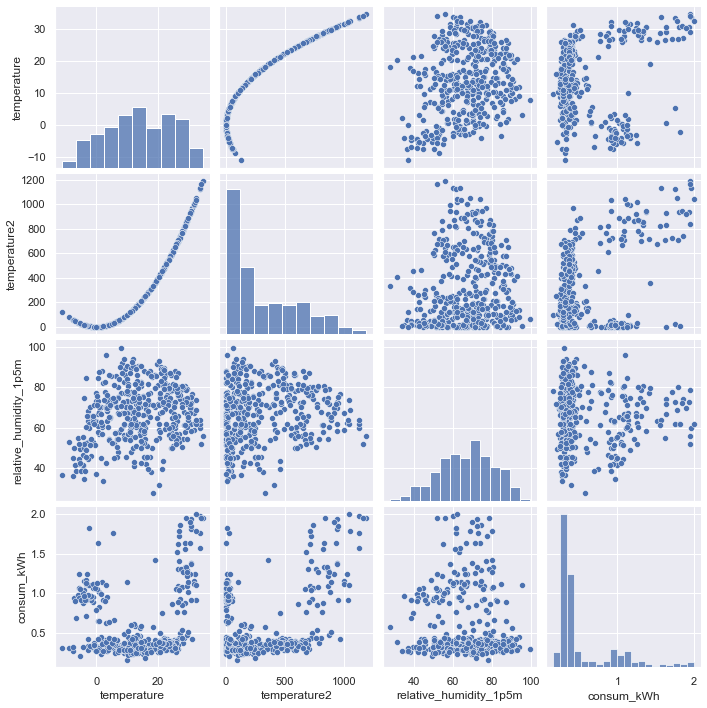

In [12]:
df_graph_2d = df_user_filter.copy()
df_graph_2d = df_user_filter.loc[:, ['temperature', 'temperature2', 'relative_humidity_1p5m', 'consum_kWh']]

sns.set(rc={'figure.figsize': (20, 20)})
sns.pairplot(df_graph_2d)

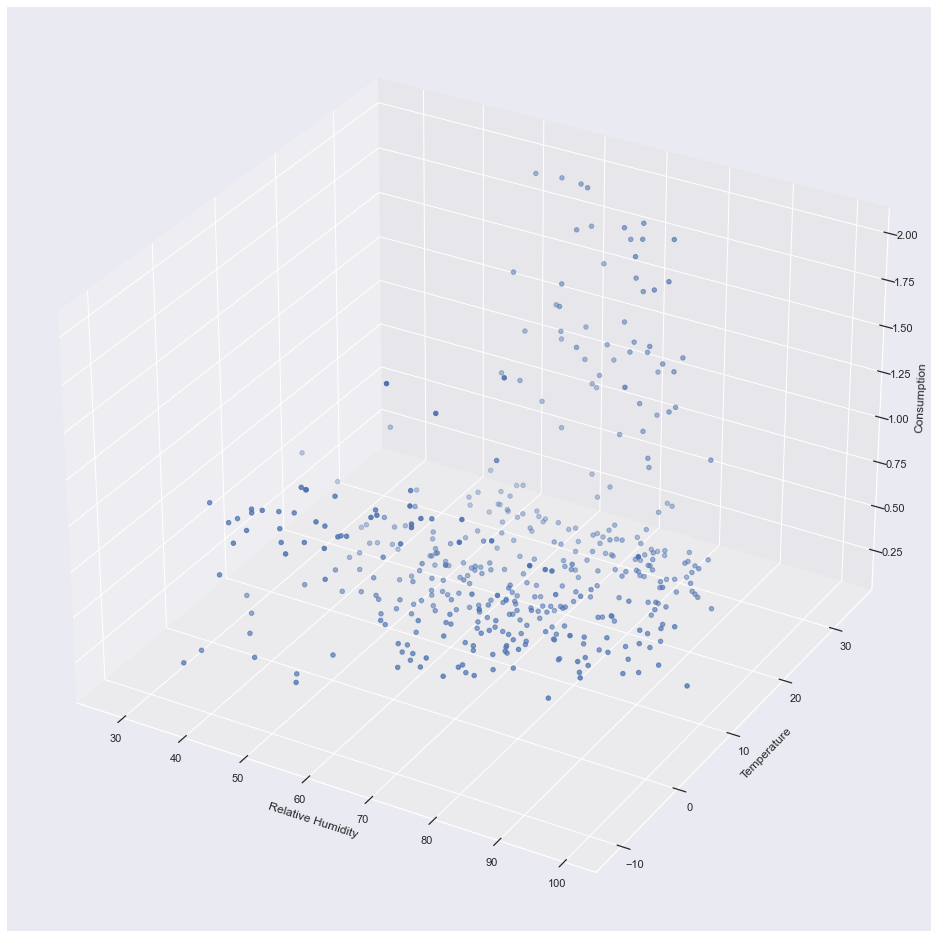

In [13]:
df_pair = df_user_filter.copy()
df_pair.loc[:, 'y'] = df_user_filter.consum_kWh

sns.set_style("darkgrid")
plt.figure(figsize=(17, 17))
axes = plt.axes(projection='3d')
axes.scatter3D(df_pair.relative_humidity_1p5m, df_pair.temperature, df_pair.consum_kWh)

axes.set_xlabel('Relative Humidity')
axes.set_ylabel('Temperature')
axes.set_zlabel('Consumption')
plt.show()

#### (3) Modeling

In [14]:
# x = df_user_filter.dropna(axis=0)[['temperature', 'temp2', 'relative_humidity_1p5m', 'temp_rel_act']]
# y = df_user_filter.dropna(axis=0)[['consum_kWh']]

# x = df_user_filter.dropna(axis=0)[['temp2', 'hour', 'relative_humidity_1p5m', 'temp_rel_act']]
# y = df_user_filter.dropna(axis=0)[['consum_kWh']]

# x = df_user_filter.dropna(axis=0)[['temperature', 'temperature2', 'uws_10m', 'vws_10m', 'relative_humidity_1p5m', 'temp_humid_interact', 'temp2_humid_interact']]
# y = df_user_filter.dropna(axis=0)[['consum_kWh']]

# x1 = df_user_filter1.dropna(axis=0)[['temperature', 'temperature2', 'relative_humidity_1p5m']]
# y1 = df_user_filter1.dropna(axis=0)[['consum_kWh']]

x = df_user_filter.dropna(axis=0)[['temperature', 'temperature2', 'relative_humidity_1p5m']]
y = df_user_filter.dropna(axis=0)[['consum_kWh']]

In [15]:
# Initialization
lin_reg = linear_model.LinearRegression(fit_intercept=True)

In [16]:
# Fitting
lin_reg_model = lin_reg.fit(x, y)

In [18]:
# Predicting(Estimated values)
y_predict = lin_reg_model.predict(x)

In [19]:
# Residuals
residuals = y - y_predict

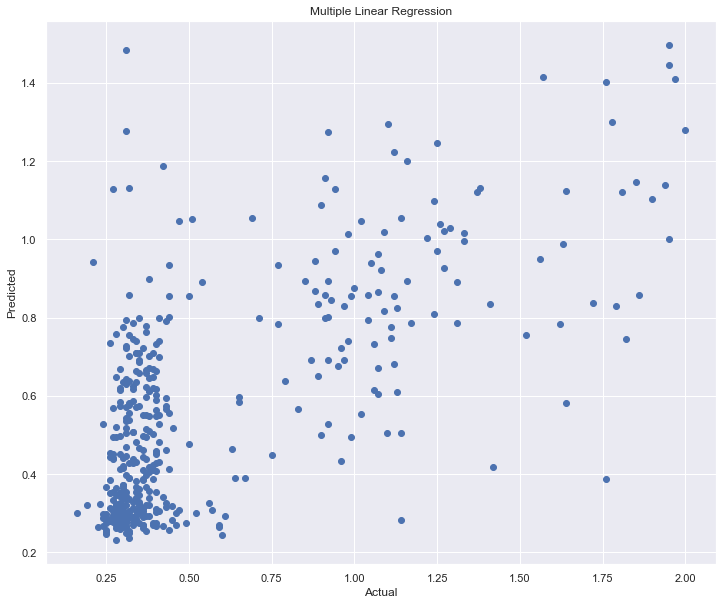

In [20]:
# Visualization confirmation
sns.set(rc={'figure.figsize': (12, 10)})
plt.scatter(y, y_predict)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Multiple Linear Regression')
plt.show()

#### (4) Checking coefficients and constants

In [21]:
print(lin_reg_model.coef_)

[[-0.05666297  0.00240411  0.00163607]]


#### (5) Accuracy Test

In [23]:
# R-Squared
print(lin_reg_model.score(x, y))

0.46639129852290817


<hr>

#### Package 2 : Statsmodels

#### (1) Checking fitting results
- F-statistic : 도출된 회귀식이 회귀분석 모델 전체에 대해 통계적으로 의미가 있는지 파악
- P-value : 각 변수가 종속변수에 미치는 영향이 유의한지 파악
- Adjusted R-square : 회귀직선이 종속변수의 몇 %를 설명할 수 있는지 확인

In [25]:
x_train_const = sm.add_constant(x)
model = sm.OLS(y, x_train_const)
results = model.fit()

In [26]:
# 결과값 요약 확인
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             consum_kWh   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     122.9
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           3.13e-57
Time:                        13:36:41   Log-Likelihood:                -97.255
No. Observations:                 426   AIC:                             202.5
Df Residuals:                     422   BIC:                             218.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.4985      0.075      6.645      0.000       0.351       0.646
temperature               -0.0567      0.004    -14.552      0.000      -0.064      -0.049
temperature2               0.0024      0.000     18.062      0.000       0.002       0.003
relative_humidity_1p5m     0.0016      0.001      1.412      0.159      -0.001       0.004
==============================================================================
Omnibus:                       65.452   Durbin-Watson:                   1.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.225
Skew:                           0.734   Prob(JB):                     7.32e-40
Kurtosis:                       5.829   Cond. No.                     2.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# VIF(분산 팽창 인수)
for i in range(1, len(model.exog_names)):
    vif = variance_inflation_factor(model.exog, i)
    print(f'Variable: {model.exog_names[i]}, VIF: {vif.round(2)}')

Variable: temperature, VIF: 7.84
Variable: temperature2, VIF: 7.5
Variable: relative_humidity_1p5m, VIF: 1.15


#### (2) Checking residuals
- 회귀모형에 대한 가정(정규성, 등분산성, 독립성)을 충족하는지에 대한 검정
- 이상치가 개입하는지에 대한 검정을 하는 절차

#### (2-1) Predicted vs Residuals

In [28]:
y_predict = y_predict.flatten()
residuals = residuals.values.flatten().tolist()

C:\Users\mazy4\anaconda3\envs\Energy_Analysis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


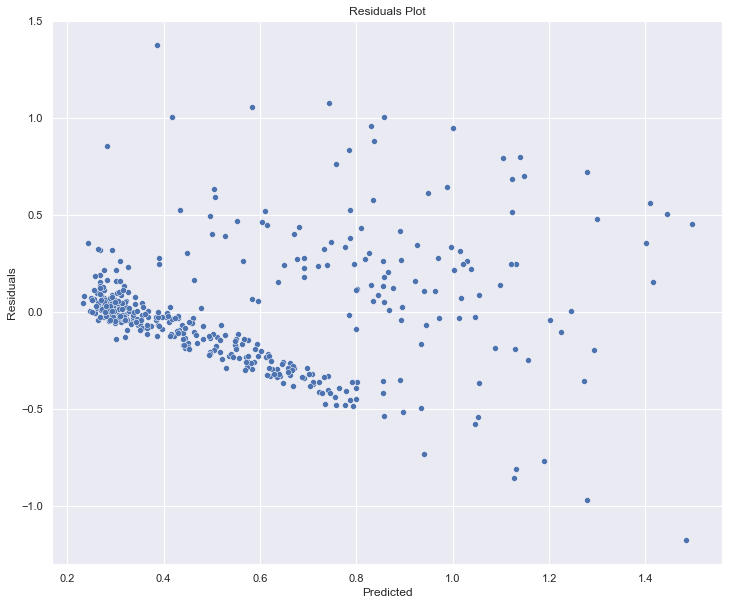

In [29]:
sns.set(rc={'figure.figsize': (12, 10)})
sns.scatterplot(y_predict, residuals)
plt.title("Residuals Plot")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

#### (2-2) Actual vs Residuals

In [30]:
y = y.values.flatten().tolist()

C:\Users\mazy4\anaconda3\envs\Energy_Analysis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


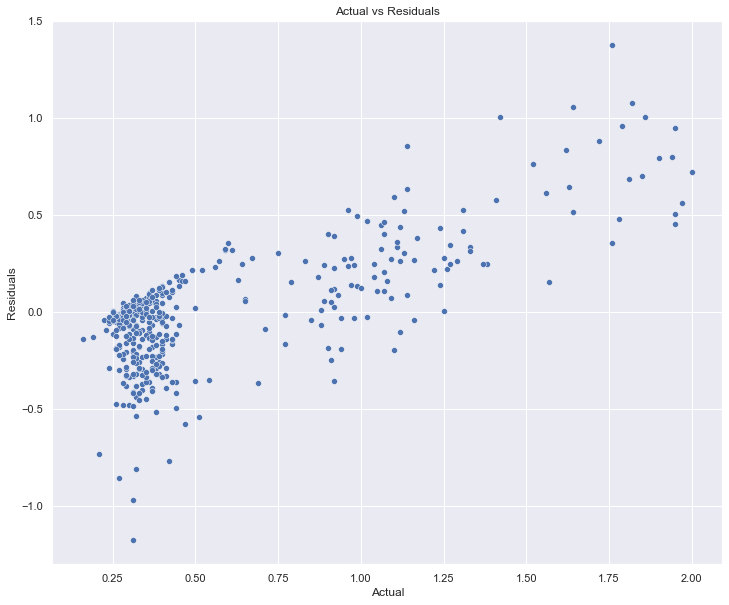

In [31]:
sns.scatterplot(y, residuals)
plt.title("Actual vs Residuals")
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.show()

#### (2-3) Temperature vs Residuals

C:\Users\mazy4\anaconda3\envs\Energy_Analysis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


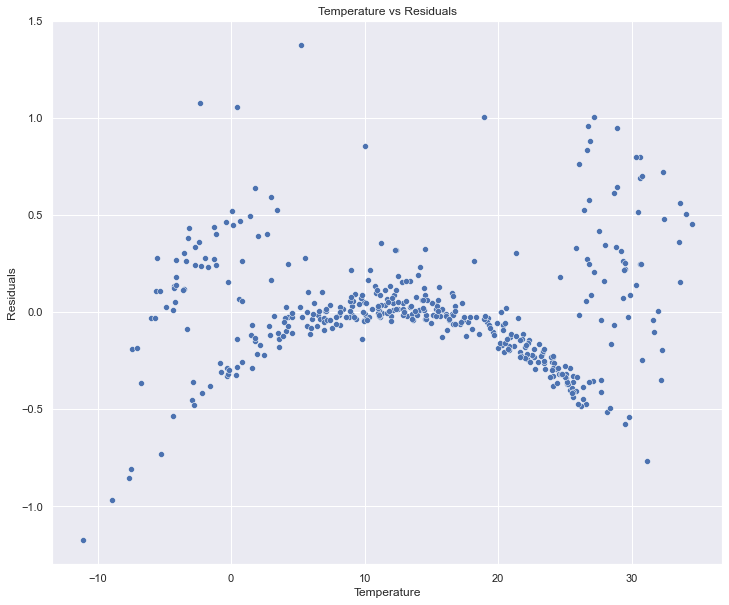

In [33]:
sns.scatterplot(x.temperature, residuals)
plt.title("Temperature vs Residuals")
plt.xlabel("Temperature")
plt.ylabel("Residuals")
plt.show()

#### (2-4) Temperature^2 vs Residuals

C:\Users\mazy4\anaconda3\envs\Energy_Analysis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


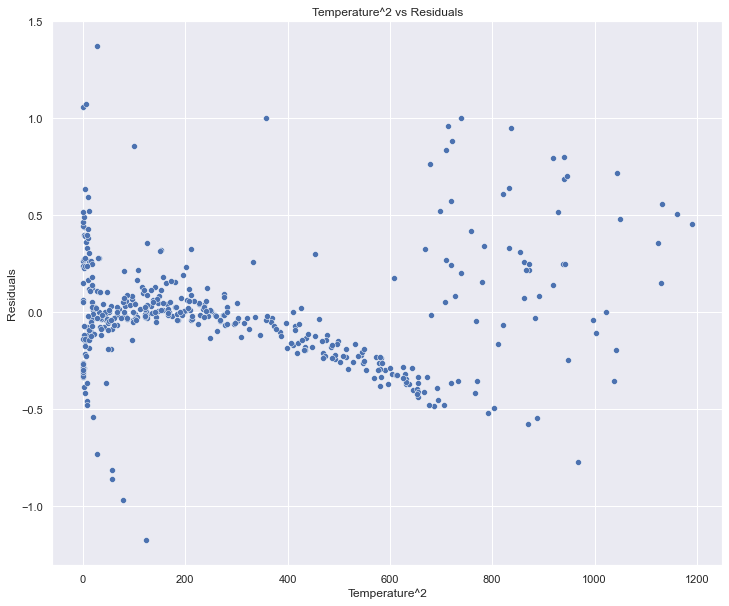

In [34]:
sns.scatterplot(x.temperature2, residuals)
plt.title("Temperature^2 vs Residuals")
plt.xlabel("Temperature^2")
plt.ylabel("Residuals")
plt.show()

#### (2-5) Relative Humidity vs Residuals

C:\Users\mazy4\anaconda3\envs\Energy_Analysis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


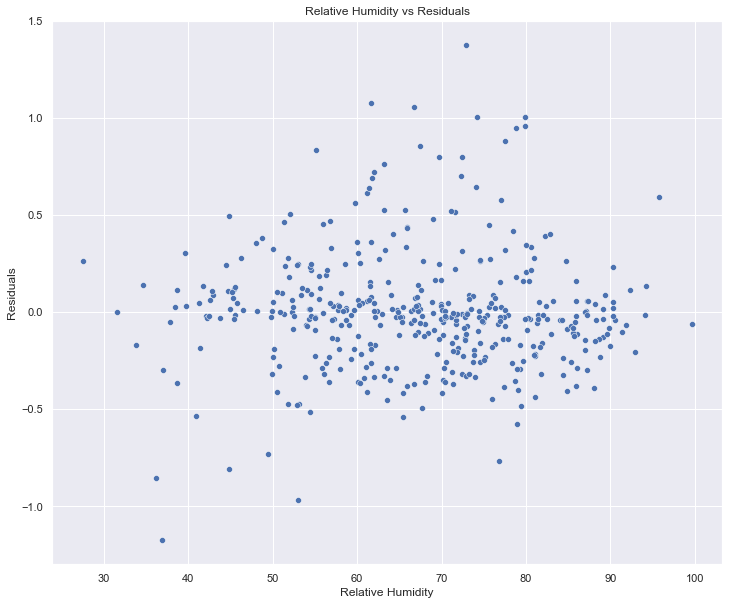

In [35]:
sns.scatterplot(x.relative_humidity_1p5m, residuals)
plt.title("Relative Humidity vs Residuals")
plt.xlabel("Relative Humidity")
plt.ylabel("Residuals")
plt.show()

<hr>

### **Conclusion and To Do**
- hour = 20으로 임의로 설정하고 교호작용(interaction) 항도 포함하여 다양한 분석을 시도했으나, 적합이 잘 되지 않는다는 문제점을 계속해서 확인하였다.
- 이로 인해, 에너지 소비량 NA값을 채우기에는 오차를 감안하더라도 제대로 추정이 되지 않을 것으로 보인다.
- 이에, 기존 1분 단위 data에서 interpolation을 진행하여 적합을 진행하고자 한다.